<div style="background-color:white;" >
<div style="clear: both; display: table;">
  <div style="float: left; width: 14%; padding: 5px; height:auto">
    <img src="img/TUBraunschweig_CO_200vH_300dpi.jpg" alt="TU_Braunschweig" style="width:100%">
  </div>
  <div style="float: left; width: 28%; padding: 5px; height:auto">
    <img src="img/TU_Clausthal_Logo.png" alt="TU_Clausthal" style="width:100%">
  </div>
  <div style="float: left; width: 25%; padding: 5px; height:auto">
    <img src="img/ostfalia.jpg" alt="Ostfalia" style="width:100%">
  </div>
  <div style="float: left; width: 21%; padding: 5px;">
    <img src="img/niedersachsen_rgb_whitebg.png" alt="Niedersachsen" style="width:100%">
  </div>
  <div style="float: left; width: 9%; padding: 5px;">
    <img src="img/internet_BMBF_gefoerdert_2017_en.jpg" alt="bmbf" style="width:100%">
  </div>
</div>
<div style="text-align:center">
<img src="img/ki4all.jpg" alt="KI4ALL-Logo" width="200"/>
</div>
</div>

# Synthetic Biomedical Data – Lesson 3a: Irrelevant Features (Noise)

Part of the *Microcredit Artificial Data Generator* learning module.

➡️ [Back to Lesson 2b: Feature Distributions and Effect Size](02b_feature_distributions_effect_size.ipynb)
➡️ [Module Overview (README)](../README.md)

---

### Recap from Lesson 2
You:
- Generated synthetic datasets and checked **class balance**.
- Explored **scatterplots** and **feature distributions**.
- Quantified separation with **effect size** (Cohen’s d, Cliff’s delta).

Now we focus on **irrelevant features** — variables that add *no* useful information about the label.


### Learning Goals
After this lesson, you will be able to:
1. **Add irrelevant features** (pure noise) to a dataset.
2. **Visualize** how noise features look vs. informative features.
3. **Quantify** which features carry signal using effect size.
4. **Explain** why irrelevant features complicate training and feature selection.

### Introduction: What are irrelevant features?

In real biomedical datasets, not every measurement is useful.
Some variables carry **no information** about the outcome of interest.
These are called **irrelevant features** (or **noise features**).

- **Examples in practice**
  - A patient’s shoe size when predicting cancer outcome.
  - Random measurement fluctuations due to instrument sensitivity.
  - Biomarkers that are measured but unrelated to the studied disease.

- **Why they matter**
  - Too many irrelevant features can **hide the true signal**.
  - They increase the risk of **overfitting**, as models may chase patterns in noise.
  - They slow down training and make feature selection more difficult.

In this lesson, we will **add irrelevant features to a synthetic dataset**
and see how they appear in plots and effect size rankings.
This builds directly on what you learned in Lesson 2 about feature distributions and effect size.

### Step 1: Start with a clean dataset

Before we add irrelevant (noise) features, we first need a **baseline dataset**
with only informative features.

This will help us:
- Compare how the dataset looks **before and after** noise is added.
- See how irrelevant features dilute the signal when they are introduced.
- Reuse the same structure you already know from Lesson 2.

Let's generate a simple dataset with `make_classification` and
inspect its first few rows.

In [15]:
# Base dataset (same pattern as Lesson 2)
from sklearn.datasets import make_classification
import numpy as np
import pandas as pd

X, y = make_classification(
    n_samples=30,
    n_features=8,       # 8 base features
    n_informative=3,    # 3 informative features
    n_redundant=0,
    n_classes=2,
    class_sep=1.2,
    random_state=42
)

feature_names = [f"feature_{i+1}" for i in range(X.shape[1])]
df = pd.DataFrame(X, columns=feature_names)
df["class"] = y

df.head()


,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,class
0,-3.241267,-1.247783,1.260513,-1.024388,-0.252568,1.632411,1.432188,2.025271,1
1,-0.236819,2.314659,-0.838923,-0.485364,0.081874,-1.867265,-2.102776,0.898786,0
2,2.122156,-0.484234,0.841991,1.032465,-1.519370,1.266911,0.621376,-0.496232,1
3,0.214094,0.385317,-0.861000,-1.245739,0.173181,-0.883857,0.903975,1.713555,1
4,1.453534,0.625667,-3.293132,-0.264657,2.720169,-0.857158,2.157449,1.972278,1


### Step 2: Add k purely random (irrelevant) features

In [16]:
# Add k purely random (irrelevant) features
rng = np.random.default_rng(7)

def add_noise_features(df, k=10, dist="normal", seed=None):
    """Append k random columns to df (excluding 'class')."""
    rng_local = np.random.default_rng(seed)
    out = df.copy()
    n = len(df)
    for i in range(k):
        if dist == "normal":
            noise = rng_local.normal(loc=0.0, scale=1.0, size=n)
        elif dist == "uniform":
            noise = rng_local.uniform(low=-1.0, high=1.0, size=n)
        else:
            raise ValueError("Supported dists: 'normal', 'uniform'")
        out[f"noise_{i+1}"] = noise
    return out

df_noise = add_noise_features(df, k=10, dist="normal", seed=123)
noise_cols = [c for c in df_noise.columns if c.startswith("noise_")]
len(noise_cols), noise_cols[:5]


(10, ['noise_1', 'noise_2', 'noise_3', 'noise_4', 'noise_5'])

### What do noise features look like?
- **Definition:** Noise (irrelevant) features have **no relationship** to the class label.
- **Visual expectation:** Their class-conditional distributions should **overlap heavily**.
- We'll compare one **informative** feature with one **noise** feature.


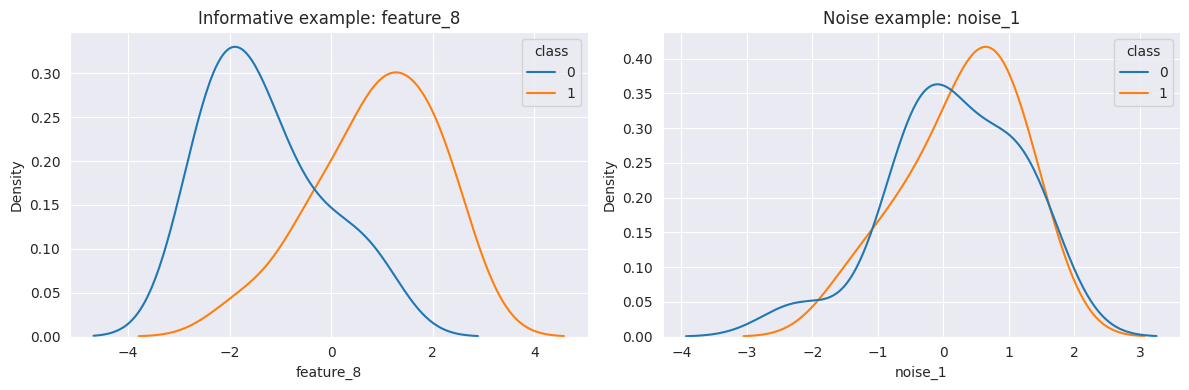

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

# Pick one likely-informative feature and one noise feature
informative_example = "feature_8"
noise_example = noise_cols[0]

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
sns.kdeplot(data=df_noise, x=informative_example, hue="class", common_norm=False)
plt.title(f"Informative example: {informative_example}")

plt.subplot(1,2,2)
sns.kdeplot(data=df_noise, x=noise_example, hue="class", common_norm=False)
plt.title(f"Noise example: {noise_example}")

plt.tight_layout()
plt.show()

### Effect size check
Visual impressions can be misleading. Let’s **quantify** class separation for the two features using **Cohen’s d**.
- Expect **larger d** for informative features.
- Expect **near 0** for noise features.


In [18]:
import numpy as np

def cohens_d(x, y):
    nx, ny = len(x), len(y)
    dof = nx + ny - 2
    pooled_std = np.sqrt(((nx - 1) * np.var(x, ddof=1) + (ny - 1) * np.var(y, ddof=1)) / dof)
    return (np.mean(x) - np.mean(y)) / pooled_std

g0_inf = df_noise.loc[df_noise["class"] == 0, informative_example]
g1_inf = df_noise.loc[df_noise["class"] == 1, informative_example]
g0_noise = df_noise.loc[df_noise["class"] == 0, noise_example]
g1_noise = df_noise.loc[df_noise["class"] == 1, noise_example]

d_inf = cohens_d(g0_inf, g1_inf)
d_noise = cohens_d(g0_noise, g1_noise)

print(f"Cohen's d — {informative_example}: {d_inf:.2f}")
print(f"Cohen's d — {noise_example}: {d_noise:.2f}")


Cohen's d — feature_8: -1.90
Cohen's d — noise_1: -0.14


In [19]:
# Rank base + noise features by absolute Cohen's d (bigger = more separating)
all_feats = [c for c in df_noise.columns if c != "class"]
rows = []
for col in all_feats:
    a = df_noise.loc[df_noise["class"] == 0, col].values
    b = df_noise.loc[df_noise["class"] == 1, col].values
    d = cohens_d(a, b)
    rows.append({"feature": col, "cohens_d": d, "abs_d": abs(d)})

rank_df = pd.DataFrame(rows).sort_values("abs_d", ascending=False)
rank_df.head(12)


,feature,cohens_d,abs_d
7,feature_8,-1.895062,1.895062
17,noise_10,-1.812739,1.812739
6,feature_7,-1.543522,1.543522
14,noise_7,0.682791,0.682791
1,feature_2,0.463935,0.463935
9,noise_2,0.427754,0.427754
2,feature_3,-0.392230,0.392230
12,noise_5,-0.343162,0.343162
11,noise_4,-0.316067,0.316067
4,feature_5,0.234663,0.234663


#### Interpretation & Reflection
- **Ranking** by |d| should list informative features near the top and noise features near the bottom.
- **Check:** Do `feature_*` columns dominate the top? Are `noise_*` near the bottom?

**Try this:**
- Increase the number of noise features to 100 in `add_noise_features`.
  - Does the top-10 list still capture informative features?
- Change the noise distribution to `"uniform"`.
  - Any difference in the ranking?


In [20]:
# Optional: train a simple classifier to see if noise hurts performance when abundant
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

X = df_noise.drop(columns=["class"]).values
y = df_noise["class"].values

X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)

clf = make_pipeline(StandardScaler(), LogisticRegression(max_iter=500))
clf.fit(X_tr, y_tr)
pred = clf.predict(X_te)
print("Logistic Regression accuracy:", round(accuracy_score(y_te, pred), 3))


Logistic Regression accuracy: 0.556


### Reflection

Take a moment to connect the code results with the concepts:

- **Visual inspection**:
  - Did the noise features look different from the informative ones in the histograms/KDE plots?
  - Could you spot noise features by eye alone?

- **Effect size**:
  - Did the calculated Cohen’s d values match your visual impression?
  - Were the informative features ranked higher than the noise features?

- **Model performance** (if you ran the optional classifier):
  - How much did adding noise affect classification accuracy?
  - What might happen if you add *hundreds* of noise features?

**Think ahead**:
In real biomedical studies, many measured variables are irrelevant.
Why is it important to detect and filter them before applying complex models?

## Exercises

1. **Add random noise features**
   - Extend your dataset with 5–10 new columns of purely random numbers
     (e.g., `np.random.normal`).
   - **Observation goal:** Do the class distributions change?
   - **Why this matters:** In real-world data, irrelevant measurements are
     always present. Models must learn to ignore them.

2. **Increase the number of irrelevant features**
   - Add 100 random features instead of 5.
   - Train a simple classifier.
   - **Observation goal:** Does performance change? Does training take longer?
   - **Why this matters:** More noise makes feature selection harder and
     increases the risk of overfitting.

> **Takeaway:**
> Irrelevant features dilute the signal. Synthetic data allows us to
> control how much noise exists, so we can test how methods behave in
> high-noise vs. low-noise scenarios.

## Quick Takeaway (3a)
- **Irrelevant features** add no predictive value and can **dilute** signal.
- Visually, noise features show **strong overlap** between classes.
- **Effect size** (e.g., Cohen’s d) helps **quantify** which features are informative.
- In high-noise settings, feature selection (next module) becomes crucial.


## Next Steps

In **Lesson 3b: Correlated Features**, you will:
- Simulate features that **move together** (e.g., biological pathways).
- Visualize correlation structures (heatmaps, pairplots).
- See how **redundancy** complicates analysis.

➡️ Continue with: **[`03b_correlated_features.ipynb`](03b_correlated_features.ipynb)`**


# Synthetic Biomedical Data – Lesson 3a: Irrelevant Features (Noise)

Part of the *Microcredit Artificial Data Generator* learning module.

➡️ [Back to Lesson 2b: Feature Distributions and Effect Size](02b_feature_distributions_effect_size.ipynb)
➡️ [Module Overview (README)](../README.md)

---

### Recap from Lesson 2
In the previous lesson, you:
- Generated your first **synthetic dataset** with controlled parameters
  (number of samples, features, and classes).
- Explored the **class distribution** to check balance between categories.
- Visualized class separability with a **scatterplot** of two features.
- Examined **feature distributions per class** using histograms, and saw that:
  - Some features are clearly informative.
  - Others behave like **noise** and do not separate classes well.

**Key takeaway:**
Synthetic datasets can be created and explored just like real biomedical data,
but with the advantage that we know which features are informative and which are not.
This makes them a safe playground for building intuition and testing methods.

---

### What’s next?

In the next lessons, we make our synthetic datasets more realistic by adding
common sources of complexity found in biomedical data.
Building on Lesson 2 (basic dataset generation), we now introduce:

- **Irrelevant features** — variables that do not contribute useful information (pure noise).
- **Correlated features** — features that move together, similar to biomarkers in the same biological pathway or proteins in the same signaling cascade.
- **Pseudo-classes** — made-up categories that mimic real subgroups but do not truly relate to the outcome.
- **Random effects** — systematic variation caused by external conditions (e.g., measurement day, lab instrument).

These additions make synthetic data more similar to real biomedical datasets,
where signals are rarely clean, features are often interdependent, and confounding effects are common.
They also provide a controlled playground to study how algorithms handle **noise, redundancy, and dependency**.

---

### Why this lesson: Irrelevant features?
In real biomedical datasets, not all collected measurements are useful.
Some features carry no signal about the outcome and act as **irrelevant features (noise)**.
If too many irrelevant features are present, they can:
- Make it harder to identify true biomarkers.
- Increase model complexity and training time.
- Lead to **overfitting** if models start learning patterns in the noise.

Synthetic data allows us to deliberately add irrelevant features to test how models and methods cope with them.

---

### Learning Goals for Lesson 3a
After completing this notebook, you will be able to:
1. **Add irrelevant features** (pure noise) to a synthetic dataset.
2. **Visualize** how irrelevant features appear in histograms and scatterplots.
3. **Compare** informative vs. irrelevant features quantitatively using effect size.
4. **Explain** why irrelevant features complicate feature selection and model training.
5. Build intuition for how **noise levels** affect machine learning performance.


# Lesson 3a: Irrelevant Features (Noise)

In the previous lesson, you generated and explored basic synthetic datasets.
Now we ask: *what happens if we add measurements that are completely unrelated to the outcome?*

### Learning Goals
- Understand the concept of **irrelevant features** (pure noise).
- Simulate irrelevant features in synthetic data.
- Explore their effect on visualization and classification.

---

## Concept
Not all measurements in a dataset are useful. Many real biomedical datasets
contain features that are unrelated to the outcome.

- **Example:** A patient’s eye color when predicting heart disease.
- These features add **noise** and can make analysis harder.

---

## Exercises
1. **Add random noise features**
   - Generate new columns with random numbers.
   - Inspect whether the class distribution changes.

2. **Increase number of irrelevant features**
   - Add 100 random features instead of 5.
   - Train a simple classifier and observe runtime/performance.

---

## Quick Takeaway
- Irrelevant features dilute the signal.
- More noise makes learning harder and increases the risk of overfitting.

---

## Next Steps
Proceed to **Lesson 3b: Correlated Features**.


## 3.1 Irrelevant Features (Noise)

Not all measurements in a dataset are useful. In fact, many real datasets
contain features that are unrelated to the outcome.

- **Example in biology:** a patient’s eye color when predicting heart disease.
- **Risk:** Models can waste capacity on noise or even mistake it for signal
  when many irrelevant features are present.
  -
- **Goal here:** learn how to add irrelevant features and see how they
  affect visualization and downstream analysis.

**TODO**: Add code to generate a dataset with a few random noise features
(e.g., `np.random.normal` values added as extra columns).

### Exercises

1. **Add random noise features**
   - Extend your dataset with 5–10 new columns of purely random numbers
     (e.g., `np.random.normal`).
   - **Observation goal:** Do the class distributions change?
   - **Why this matters:** In real-world data, irrelevant measurements are
     always present. Models must learn to ignore them.

2. **Increase the number of irrelevant features**
   - Add 100 random features instead of 5.
   - Train a simple classifier.
   - **Observation goal:** Does performance change? Does training take longer?
   - **Why this matters:** More noise makes feature selection harder and
     increases the risk of overfitting.

> **Takeaway:**
> Irrelevant features dilute the signal. Synthetic data allows us to
> control how much noise exists, so we can test how methods behave in
> high-noise vs. low-noise scenarios.